## <div style= 'color: White'> This is the final 3 output code

In [2]:
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
%matplotlib widget

### <div style= 'color: yellow'> Create dataset


In [ ]:
# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
NUM_FILES_TO_USE = 399700 # Increased for better generalization
DATA_DIR_PATH = "/home/kay/ML-for-Neutron-Stars/3_PP_EOS_emulator_real_data/All_MR_Relations/All_MR_Relations/"
BATCH_SIZE = 256 # Larger batch size for smoother gradients
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Regex to extract parameters
pattern = re.compile(
    r"MREoSm(?P<m>\d+)"
    r"L(?P<L>\d+)"
    r"J(?P<J>\d+)"
    r"T(?P<T>\d+)_"
    r"n(?P<n>\d+)_"
    r"Yp?\+.*?RGgen_"
    r"v(?P<n_v>[-\d\.]+)"
    r"d(?P<d>[-\d\.]+)"
    r"B(?P<Btype>[np])(?P<B>\d+)\.dat"
)

# ==============================================================================
# 2. DATA PROCESSING (SPLIT BY FILE)
# ==============================================================================
all_files = glob.glob(os.path.join(DATA_DIR_PATH, "MR*.dat"))
if not all_files: raise RuntimeError("No files found.")

# Shuffle FILES first, then split
np.random.shuffle(all_files)
selected_files = all_files[:NUM_FILES_TO_USE]

# Split files into Train and Validation lists (80/20 split)
split_idx = int(0.8 * len(selected_files))
train_files = selected_files[:split_idx]
val_files = selected_files[split_idx:]

def process_files(file_list, label_desc):
    dataset_rows = []
    files_used_for_training = []
    
    for file_path in tqdm(file_list, desc=f"Processing {label_desc}"):
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if not match: continue

        files_used_for_training.append(file_path)

        # --- FIX 1: Extract ALL parameters ---
        m = float(match.group("m")) / 100.0 
        L = float(match.group("L"))
        J = float(match.group("J"))             
        T = float(match.group("T")) # Unused but extracted for completeness             
        n = float(match.group('n')) / 1000.0
        n_v = float(match.group("n_v"))
        d = float(match.group("d"))
        B = float(match.group("B")) / 1000.0
        
        try:
            data = np.loadtxt(file_path)
        except: continue

        if data.ndim == 1 or data.shape[1] < 3: continue

        # Columns: [Central pressure (P_c), Mass, Radius, Tidal Deformability, R_quarkcore, Baryonic mass (rho)]
        cp = data[:, 0]
        mass = data[:, 1]
        radius = data[:, 2]
        td = data[:, 3]

        # --- Filter Unstable Branch ---
        # We only want data up to the Maximum Mass. 
        # Usually data is sorted by Pc. M increases then decreases.
        max_m_index = np.argmax(mass)
        
        # --- Truncate BEFORE the noisy peak at M_max ---
        # Drop the last 2 points from the calculated stable branch
        SAFETY_MARGIN = 2 
        
        # Ensure we don't end up with negative index
        end_index = max(1, max_m_index + 1 - SAFETY_MARGIN)
        
        # Slice arrays to only keep stable, safe branch
        cp = cp[:end_index]
        mass = mass[:end_index] 
        radius = radius[:end_index]
        td = td[:end_index]

        # Apply Minimum Mass Cutoff (Filter low-mass instability)
        M_CUTOFF = 0.15 # Filter out anything below 0.15 solar masses
        low_mass_mask = mass >= M_CUTOFF
        cp= cp[low_mass_mask]
        mass = mass[low_mass_mask]
        radius = radius[low_mass_mask]
        td = td[low_mass_mask]

        # Basic filtering
        valid_mask = (radius > 0) & (mass > 0)
        cp = cp[valid_mask]
        mass = mass[valid_mask]
        radius = radius[valid_mask]
        td = td[valid_mask]

        if len(mass) == 0: continue

        # Create feature vector for every point
        # Features: [m, L, J, n_v, d, B, n, cp] -> Predict: Mass, Radius, TD
        num_points = len(mass)
        eos_params = np.array([m, L, J, n_v, d, B, n])
        
        # Tile EOS params to match number of mass points
        eos_repeated = np.tile(eos_params, (num_points, 1))

        # Stack: [EOS_Params (7), Central Pressure (1), Mass (1), Radius (1)]
        rows = np.column_stack([eos_repeated, cp, mass, radius, td])
        dataset_rows.append(rows)

    if not dataset_rows: return None
    return np.vstack(dataset_rows), np.array(files_used_for_training)

print("Building Training Set...")
train_data = process_files(train_files, "Train")
print("Building Validation Set...")
val_data = process_files(val_files, "Val")
print("Datasets created!")

print(train_data[1].shape)
print(val_data[1].shape)

files_used_for_training = np.concatenate([train_data[1], val_data[1]]) if train_data and val_data is not None else []

save_dir = f"{NUM_FILES_TO_USE}files"
# Create folder if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "train_data_files.npy"), train_data[0])
np.save(os.path.join(save_dir, "val_data_files.npy"), val_data[0])
np.save(os.path.join(save_dir, "files_used_for_training.npy"), files_used_for_training)

print("Datasets saved!")

# <div style= 'color: red'> FROM HERE ON USE CLUSTER FILES train_real.py AND test.py, FOR BIGGER RUNS

### <div style= 'color: yellow'> Loading Datasets 

In [6]:
save_dir = "399700files_MRTD/"

In [7]:
train_data = np.load(os.path.join(save_dir, "train_data_files.npy"))
val_data = np.load(os.path.join(save_dir, "val_data_files.npy"))

In [3]:
files_used_for_training = np.load(os.path.join(save_dir, "files_used_for_training.npy"))

In [ ]:
train_data.shape, val_data.shape

### <div style= 'color: orange'> Range of values of the parameters from the dataset

In [8]:
print("Nuclear Mass min/max:", np.round(train_data[:, 0].min(), 3), np.round(train_data[:, 0].max(), 3))
print("Slope parmeter min/max:", np.round(train_data[:, 1].min(), 3), np.round(train_data[:, 1].max(), 3))
print("Symmetry Energy min/max:", np.round(train_data[:, 2].min(), 3), np.round(train_data[:, 2].max(), 3))
print("Vector coupling min/max:", np.round(train_data[:, 3].min(), 3), np.round(train_data[:, 3].max(), 3))
print("Diquark coupling min/max:", np.round(train_data[:, 4].min(), 3), np.round(train_data[:, 4].max(), 3))
print("Bag constant min/max:", np.round(train_data[:, 5].min(), 3), np.round(train_data[:, 5].max(), 3))
print("Number of particles min/max:", np.round(train_data[:, 6].min(), 3), np.round(train_data[:, 6].max(), 3))
print("Central Pressure min/max:", np.round(train_data[:, 7].min(), 3), np.round(train_data[:, 7].max(), 3))

print("Mass min/max:", np.round(train_data[:, 8].min(), 3), np.round(train_data[:, 8].max(), 3))
print("Radius min/max:", np.round(train_data[:, 9].min(), 3), np.round(train_data[:, 9].max(), 3))
print("Tidal Deformability min/max:", np.round(train_data[:, 10].min(), 3), np.round(train_data[:, 10].max(), 3))

train_data.shape

Nuclear Mass min/max: 0.55 0.75


KeyboardInterrupt: 

### <div style= 'color: orange'> Produce a mass-radius curve for a single EOS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Extract ONE eos curve
# -------------------------------------------------------
# Pick a specific index (0 = first file in train_data before shuffling)
# But because the train_data is shuffled, we instead extract a *single EOS*
# by matching identical (m, L, J, n_v, d, B, n).
# Selecting the EOS at index 20000 for variety
m0, L0, J0, nv0, d0, B0, n0 = train_data[20000, :7]

mask = (
    (train_data[:,0] == m0)  &
    (train_data[:,1] == L0)  &
    (train_data[:,2] == J0)  &
    (train_data[:,3] == nv0) &
    (train_data[:,4] == d0)  &
    (train_data[:,5] == B0)  &
    (train_data[:,6] == n0)
)

subset = train_data[mask]

mass = subset[:, 8]
radius = subset[:, 9]

# Sort by mass so plot looks clean
order = np.argsort(mass)
mass = mass[order]
radius = radius[order]

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
plt.figure(figsize=(6,5))
plt.plot(radius, mass, linewidth=2)
plt.xlabel("Radius [km]")
plt.ylabel("Mass [M☉]")
plt.title(f"EOS sanity check\nm={m0}, L={L0}, J={J0}, n_v={nv0}, d={d0}, B={B0}, n={n0}")
plt.grid(True)
plt.show()


### <div style= 'color: orange'> Produce a TD-compactness curve for a single EOS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# Extract ONE eos curve
# -------------------------------------------------------
# Pick a specific index (0 = first file in train_data before shuffling)
# But because the train_data is shuffled, we instead extract a *single EOS*
# by matching identical (m, L, J, n_v, d, B, n).
# Selecting the EOS at index 20000 for variety
m0, L0, J0, nv0, d0, B0, n0 = train_data[20000, :7]

mask = (
    (train_data[:,0] == m0)  &
    (train_data[:,1] == L0)  &
    (train_data[:,2] == J0)  &
    (train_data[:,3] == nv0) &
    (train_data[:,4] == d0)  &
    (train_data[:,5] == B0)  &
    (train_data[:,6] == n0)
)

subset = train_data[mask]

mass = subset[:, 8]
radius = subset[:, 9]
td = np.log10(subset [:, 10])

# Sort by mass so plot looks clean
order = np.argsort(mass)
mass = mass[order]
radius = radius[order]
td = td[order]

# Calculate compactness
compact = mass / radius

# -------------------------------------------------------
# Plot
# -------------------------------------------------------
plt.figure(figsize=(6,5))
plt.plot(compact, td, linewidth=2)
plt.xlabel("Compactness (M/R)")
plt.ylabel("Tidal Deformability (log_10)")
plt.title(f"EOS sanity check\nm={m0}, L={L0}, J={J0}, n_v={nv0}, d={d0}, B={B0}, n={n0}")
plt.grid(True)
plt.show()


### <div style= 'color: yellow'> Data processing pipeline

* Z_Score normalization: $X_{\text{norm}, i} = (X_i - \mu_i) / \sigma_i$
* Constant Scaling: $X_{\text{norm}, M} = X_M / 3.5$

In [ ]:
# Convert to Tensor
# Inputs: Cols 0 to 7 (8 features: m, L, J, n_v, d, B, n, cp)
# Output: Col 8, 9 and 10 (Mass, Radius, Tidal Deformability)
X_train = torch.tensor(train_data[:, :8], dtype=torch.float32)
y_train = torch.tensor(train_data[:, 8:], dtype=torch.float32)

X_val = torch.tensor(val_data[:, :8], dtype=torch.float32)
y_val = torch.tensor(val_data[:, 8:], dtype=torch.float32)

# 1. Separate Central Pressure (index 7) from EOS parameters (indices 0-7)
X_eos_train, X_cp_train = X_train[:, :7], X_train[:, 7:]
X_eos_val, X_cp_val = X_val[:, :7], X_val[:, 7:]

# 2.1 Normalize using log scaling on Central Pressure (cp)
X_cp_train_norm = torch.log10(X_cp_train)
X_cp_val_norm = torch.log10(X_cp_val)

# 2.2 Normalize using Z-Score on EOS Parameters (m, L, J, n_v, d, B, n)
X_eos_mean = X_eos_train.mean(dim=0, keepdim=True)
X_eos_std = X_eos_train.std(dim=0, keepdim=True)
X_eos_std[X_eos_std == 0] = 1.0 

# Save them:
torch.save(X_eos_mean, os.path.join(save_dir, "X_eos_mean.pt"))
torch.save(X_eos_std, os.path.join(save_dir, "X_eos_std.pt"))
print("Normalization statistics saved.")

X_eos_train_norm = (X_eos_train - X_eos_mean) / X_eos_std
X_eos_val_norm = (X_eos_val - X_eos_mean) / X_eos_std

# 3. --- Recombine inputs ---
X_train_norm = torch.cat((X_eos_train_norm, X_cp_train_norm), dim=1)
X_val_norm = torch.cat((X_eos_val_norm, X_cp_val_norm), dim=1)


# 4. Separate Mass, Radius and Tidal Deformability
y_mass_train, y_radius_train, y_td_train = y_train[:, 0:1], y_train[:, 1:2], y_train[:, 2:3]
y_mass_val, y_radius_val, y_td_val = y_val[:, 0:1], y_val[:, 1:2], y_val[:, 2:3]

# 5.1 Normalize using Constant Scaling on Mass (M)
MASS_SCALE = 3.5 
y_mass_train_norm = y_mass_train / MASS_SCALE
y_mass_val_norm = y_mass_val / MASS_SCALE

# 5.2. Normalize using Constant Scaling on Radius (R)
RADIUS_SCALE = 25.0
y_radius_train_norm = y_radius_train / RADIUS_SCALE
y_radius_val_norm = y_radius_val / RADIUS_SCALE

# 5.3 Normalize using log scaling on Tidal Deformability (td)
y_td_train_norm = torch.log10(y_td_train)
y_td_val_norm = torch.log10(y_td_val)

# 6. --- Recombine Outputs ---
y_train_norm = torch.cat((y_mass_train_norm, y_radius_train_norm, y_td_train_norm), dim=1)
y_val_norm = torch.cat((y_mass_val_norm, y_radius_val_norm, y_td_val_norm), dim=1)

# Note: You no longer need y_mean and y_std for normalization, 
# but you MUST save RADIUS_SCALE, MASS_SCALE and inverse log for cp to de-normalize predictions later.

### <div style= 'color: orange'> Range of values of the parameters after scaling and normalizing

In [ ]:
print("Nuclear Mass min/max:", np.round(X_train_norm[:, 0].min(), 3), np.round(X_train_norm[:, 0].max(), 3))
print("Slope parmeter min/max:", np.round(X_train_norm[:, 1].min(), 3), np.round(X_train_norm[:, 1].max(), 3))
print("Symmetry Energy min/max:", np.round(X_train_norm[:, 2].min(), 3), np.round(X_train_norm[:, 2].max(), 3))
print("Vector coupling min/max:", np.round(X_train_norm[:, 3].min(), 3), np.round(X_train_norm[:, 3].max(), 3))
print("Diquark coupling min/max:", np.round(X_train_norm[:, 4].min(), 3), np.round(X_train_norm[:, 4].max(), 3))
print("Bag constant min/max:", np.round(X_train_norm[:, 5].min(), 3), np.round(X_train_norm[:, 5].max(), 3))
print("Number of particles min/max:", np.round(X_train_norm[:, 6].min(), 3), np.round(X_train_norm[:, 6].max(), 3))
print("Central Pressure min/max:", np.round(X_train_norm[:, 7].min(), 3), np.round(X_train_norm[:, 7].max(), 3))

print("Mass min/max:", np.round(y_train_norm[:, 0].min(), 3), np.round(y_train_norm[:, 0].max(), 3))
print("Radius min/max:", np.round(y_train_norm[:, 1].min(), 3), np.round(y_train_norm[:, 1].max(), 3))
print("Tidal Deformability min/max:", np.round(y_train_norm[:, 2].min(), 3), np.round(y_train_norm[:, 2].max(), 3))

### <div style= 'color: yellow'> Define Model

In [3]:
class ResNetBlock(nn.Module):
    def __init__(self, hidden_dim, auxiliary_dim=1):
        super().__init__()
        # We accept the hidden state + the auxiliary Central Pressure injection
        self.fc = nn.Linear(hidden_dim + auxiliary_dim, hidden_dim)
        self.act = nn.GELU() # Gaussian Error Linear Unit
    
    def forward(self, x, cp):
        # Concatenate Central Pressure to the input of the layer
        combined = torch.cat([x, cp], dim=1)
        out = self.act(self.fc(combined))
        return x + out # Residual connection

class PhysicsEmulator(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=512): 
        super().__init__()
        # Separate EOS inputs from Central Pressure
        # input_dim is 8: (7 EOS params + 1 Central Pressure)
        self.eos_dim = input_dim - 1 
        
        # 1. Initial encoding of EOS parameters only: 
        self.input_layer = nn.Linear(self.eos_dim, hidden_dim)
        
        # 2. Deep Residual Layers with Central Pressure Injection
        self.block1 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block2 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block3 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block4 = ResNetBlock(hidden_dim, auxiliary_dim=1)

        # 3. Output layers
        self.final_layer = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim // 2), # Inject Central Pressure one last time
            nn.GELU(),                                      # 513 --> 256
            nn.Linear(hidden_dim // 2, 3)                   # Output: 256 --> 3
        )
        
    def forward(self, x):
        # Split input into EOS params and Central Pressure
        # Central Pressure is the LAST column (index -1)
        eos_params = x[:, :-1]
        cp = x[:, -1:]
        
        # 1. Encode EOS
        x_hidden = self.input_layer(eos_params)             # Input: 7 --> 512

        # 2. Central Pressure-Injected Residual Flow: Pass through blocks, injecting Central Pressure at each step
        x_hidden = self.block1(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block2(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block3(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block4(x_hidden, cp)              # 512 + 1 --> 512
        
        # 3. Final Prediction
        # Concatenate Central Pressure one last time for the read-out
        combined_final = torch.cat([x_hidden, cp], dim=1) # 512 + 1 = 513
        return self.final_layer(combined_final)             

### <div style= 'color: yellow'> Train Model

In [ ]:
# --- Helper function for plotting ---
def plot_and_save_losses(train_losses, val_losses, filename="loss_curve.png"):
    """Plots training and validation loss and saves the figure."""
    epochs = range(len(train_losses))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Huber Loss (Normalized)')
    plt.yscale('log') # Use log scale for clearer visualization of small losses
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    try:
        plt.savefig(os.path.join(save_dir, filename))
        print(f"Loss plot saved to {filename}", flush=True)
    except Exception as e:
        print(f"ERROR saving plot: {e}", flush=True)
    plt.close()
# --------------------------------------------------------------------------


model = PhysicsEmulator().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-7)
criterion = nn.HuberLoss()

# ==============================================================================
# 5. TRAINING
# ==============================================================================
# Ensure Mass and Radius are Torch Tensors (it might be a numpy array currently)
if isinstance(y_train_norm, np.ndarray):
    y_train_norm = torch.from_numpy(y_train_norm).to(torch.float32)
if isinstance(y_val_norm, np.ndarray):
    y_val_norm = torch.from_numpy(y_val_norm).to(torch.float32)

# Update your DataLoaders
train_loader = DataLoader(TensorDataset(X_train_norm, y_train_norm), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_norm, y_val_norm), batch_size=BATCH_SIZE, shuffle=False)
epochs = 100 
best_loss = float('inf')

# 1. ADD STORAGE LISTS
train_losses = []
val_losses = []
# Ensure MASS_SCALE and RADIUS_SCALE are defined globally or passed in if running as a function
# If you didn't define save_dir, model will save in current directory.

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_b, y_b in train_loader:
        X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
        optimizer.zero_grad()
        pred = model(X_b)
        loss = criterion(pred, y_b)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
            pred = model(X_b)
            loss = criterion(pred, y_b)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    scheduler.step()
    
    # 2. APPEND LOSSES
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        # Removed os.path.join(save_dir, "Best_EOS_Model.pth") for simplicity, assuming current directory
        torch.save(model.state_dict(), os.path.join(save_dir, "Best_EOS_Model.pth"))
        
        
    
    if epoch % 10 == 0:
        # Calculate the Approximate Physical Error in km
        phys_error_km = np.sqrt(2 * val_loss) * RADIUS_SCALE 
        mass_error = np.sqrt(2 * val_loss) * MASS_SCALE
        td_error = np.sqrt(2 * val_loss)  # Since td is log-scaled, this is in log units

        print(f"Epoch {epoch} | Val Loss: {val_loss:.6e} | Approx Radius Error: {phys_error_km:.4f} km | Approx Mass Error: {mass_error:.4f} | Approx TD error: {td_error:.4f}", flush=True)

        # 3. PLOT AND SAVE PERIODICALLY
        # Plot every 50 epochs (or choose a different interval)
        if epoch % 50 == 0 and epoch > 0:
            plot_and_save_losses(train_losses, val_losses, filename=f"loss_curve_epoch{epoch}.png")

# 4. FINAL PLOT after training finishes
plot_and_save_losses(train_losses, val_losses, filename="loss_curve_final.png")

### <div style= 'color: yellow'> Testing the model

Total files available: 399755
Length of training set: 399700
Total unseen files available for testing: 55
MR plot   : 10 unseen files
TD plot   : 1 unseen files
Using existing normalization statistics in memory.


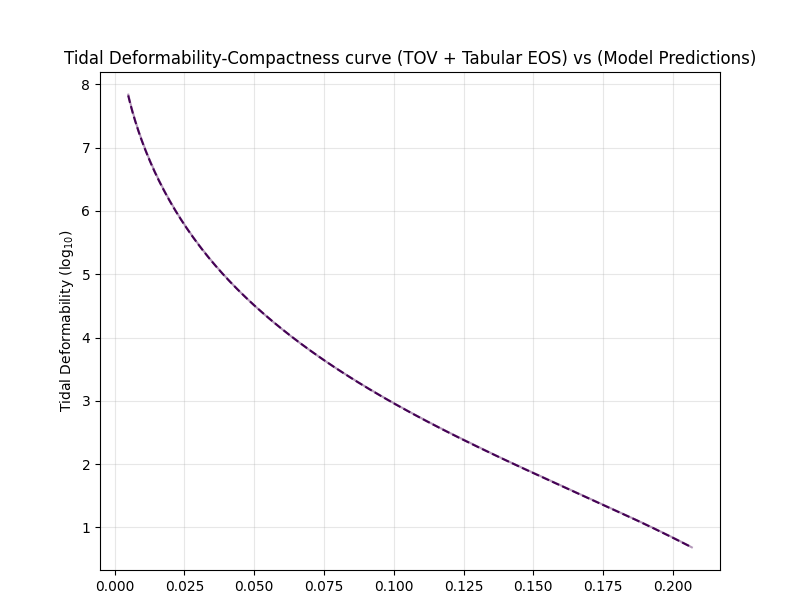

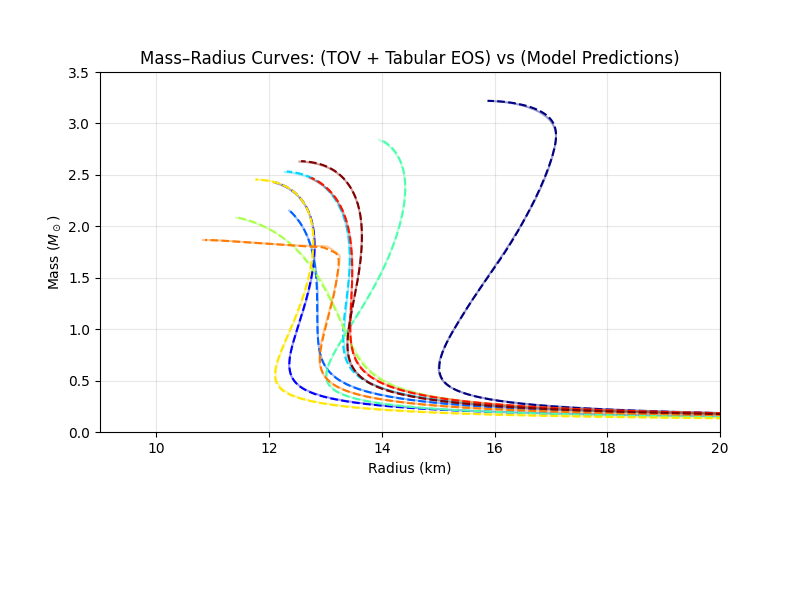

In [ ]:
# ==============================================================================
# 1. CONFIGURATION & HELPERS
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RADIUS_SCALE = 25.0
MASS_SCALE = 3.5
# How many unseen EOS to plot
N_MR_FILES = 10          # for Mass–Radius plot <-------------------------------
N_TD_FILES = 1          # for Compactness–Tidal plot <-------------------------

MODEL_NO = 4             # For saving plots <------------------------------------

# Regex must match the Training Pipeline exactly
pattern = re.compile(
    r"MREoSm(?P<m>\d+)"
    r"L(?P<L>\d+)"
    r"J(?P<J>\d+)"
    r"T(?P<T>\d+)_"
    r"n(?P<n>\d+)_"
    r"Yp?\+.*?RGgen_"
    r"v(?P<n_v>[-\d\.]+)"
    r"d(?P<d>[-\d\.]+)"
    r"B(?P<Btype>[np])(?P<B>\d+)\.dat"
)

def extract_eos_params(filename):
    match = pattern.match(filename)
    if not match:
        return None
    
    # Extract raw values exactly like training
    m = float(match.group("m")) / 100.0
    L = float(match.group("L"))
    J = float(match.group("J"))
    n_v = float(match.group("n_v"))
    d = float(match.group("d"))
    B = float(match.group("B")) / 1000.0
    n = float(match.group('n')) / 1000.0  # e.g., 0.160
    
    # Return as a numpy array for easy stacking [m, L, J, n_v, d, B, n]
    return np.array([m, L, J, n_v, d, B, n], dtype=np.float32)

# ==============================================================================
# 2. SELECT "UNSEEN" FILES
# ==============================================================================
# Path to your data
DATA_DIR_PATH = "/home/kay/ML-for-Neutron-Stars/All_MR_Relations/All_MR_Relations/"
all_files = glob.glob(os.path.join(DATA_DIR_PATH, "MR*.dat"))
print("Total files available:", len(all_files))

# Load the list of files used for training
# Ensure this file exists from your training run!
try:
    training_files_used = np.load(os.path.join(save_dir, "files_used_for_training.npy"), allow_pickle=True)
    # Convert to set for fast lookup
    training_set = {
    os.path.basename(f) for f in training_files_used        
    }
    print("Length of training set:", len(training_set))
except FileNotFoundError:
    print("Warning: List of training files not found. Using random files (risk of data leakage).")
    training_set = {
    os.path.basename(f) for f in training_files_used        
    }
    print("Length of random training set:", len(training_set))

# Filter: Keep only files NOT in the training set
test_pool = [
    f for f in all_files
    if os.path.basename(f) not in training_set
]
print("Total unseen files available for testing:", len(test_pool))

# Ensure we have enough unseen files
if len(test_pool) < max(N_MR_FILES, N_TD_FILES):
    raise RuntimeError("Not enough unseen files available.")

selected_files_MR = np.random.choice(
    test_pool, size=N_MR_FILES, replace=False
)
selected_files_TD = np.random.choice(
    test_pool, size=N_TD_FILES, replace=False
)
print(f"MR plot   : {len(selected_files_MR)} unseen files")
print(f"TD plot   : {len(selected_files_TD)} unseen files")

# ==============================================================================
# 3. PREPARE MODEL & SCALERS
# ==============================================================================
# Load Model
model = PhysicsEmulator(input_dim=8).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(save_dir, "Best_EOS_Model.pth"), map_location=DEVICE))
model.eval()

# IMPORTANT: You must use the SAME mean/std from TRAINING.
# If you are in a new session, you should have saved these. 
# For now, assuming they exist in memory or you manually input them.
# Example: 
# X_eos_mean = torch.load("Datasets/X_eos_mean.pt")
# X_eos_std = torch.load("Datasets/X_eos_std.pt")

if 'X_eos_mean' not in locals():
    # Loading the SAME mean/std from TRAINING.
    X_eos_mean = torch.load(os.path.join(save_dir, "X_eos_mean.pt"), map_location=DEVICE)
    X_eos_std = torch.load(os.path.join(save_dir, "X_eos_std.pt"), map_location=DEVICE)
    print("Using saved normalization statistics.")
else:
    print("Using existing normalization statistics in memory.")
    X_eos_mean = X_eos_mean.to(DEVICE)
    X_eos_std = X_eos_std.to(DEVICE)

# ==============================================================================
# 4. EVALUATION LOOP
# ==============================================================================
fig1, ax1 = plt.subplots(figsize=(8, 6))
fig2, ax2 = plt.subplots(figsize=(8, 6))

# ------------------------------------------------------------------------------
# M-R plot loop
# ------------------------------------------------------------------------------

colors_MR = plt.cm.jet(np.linspace(0, 1, len(selected_files_MR)))

for color, file_path in zip(colors_MR, selected_files_MR):

    filename = os.path.basename(file_path)
    eos_params = extract_eos_params(filename)
    if eos_params is None:
        continue

    # load data
    try:
        data = np.loadtxt(file_path)
    except Exception:
        continue

    # get cp, mass and radius values
    cp_vals     = data[:, 0]    
    mass_vals   = data[:, 1]
    radius_vals = data[:, 2]

    # Fix to only use stable branch up to M_max - 2 points
    max_m_idx = np.argmax(mass_vals)
    cut_idx = max(1, max_m_idx - 2)

    cp_vals     = cp_vals[:cut_idx]
    mass_vals   = mass_vals[:cut_idx]
    radius_vals = radius_vals[:cut_idx]

    # Basic filtering to ensure positive values
    valid_mask = (radius_vals > 0) & (mass_vals > 0)

    cp_vals     = cp_vals[valid_mask]
    mass_vals   = mass_vals[valid_mask]
    radius_vals = radius_vals[valid_mask]


    # ---------------------------------------------------------
    # PREPARE INPUT TENSORS (The Hybrid Normalization)
    # ---------------------------------------------------------
    # 1. Tile the EOS params for every mass point
    num_points = len(mass_vals)
    eos_repeated = np.tile(eos_params, (num_points, 1))

    # 2. Convert to Tensor
    X_eos_input  = torch.tensor(eos_repeated, dtype=torch.float32, device=DEVICE)
    X_cp_input = torch.tensor(cp_vals[:, None], dtype=torch.float32, device=DEVICE)

    # 3. NORMALIZE (Use training stats!)
    # EOS: Z-scor
    X_eos_norm  = (X_eos_input - X_eos_mean) / X_eos_std
    # CP: Log Scaling
    X_cp_norm = torch.log10(X_cp_input)

    # 4. Concatenate inputs
    model_input = torch.cat((X_eos_norm, X_cp_norm), dim=1)

    # ---------------------------------------------------------
    # PREDICT AND DE-NORMALIZE
    # ---------------------------------------------------------
    with torch.no_grad():
        pred = model(model_input)
        M_pred = (pred[:, 0] * MASS_SCALE).cpu().numpy()
        R_pred_km = (pred[:, 1] * RADIUS_SCALE).cpu().numpy()

    label = (
        f"m={eos_params[0]:.2f}, L={eos_params[1]:.0f}, "
        f"J={eos_params[2]:.0f}, n_v={eos_params[3]:.2f},"
        f"d={eos_params[4]:.2f}, B={eos_params[5]:.3f}, "
        f"n={eos_params[6]:.3f}, cp = {cp_vals[0]:.2f}"
    )

    # ---------------------------------------------------------
    # PLOT [m, L, J, n_v, d, B, n] # Label with Physics Params
    # ---------------------------------------------------------
    ax1.plot(radius_vals, mass_vals, "-", color=color, alpha=0.4)
    ax1.plot(R_pred_km, M_pred, "--", color=color, label=label)

    colors_TD = plt.cm.viridis(np.linspace(0, 1, len(selected_files_TD)))

# ------------------------------------------------------------------------------
# Tidal Deformability plot loop
# ------------------------------------------------------------------------------

for color, file_path in zip(colors_TD, selected_files_TD):

    filename = os.path.basename(file_path)
    eos_params = extract_eos_params(filename)
    if eos_params is None:
        continue

    # load data
    try:
        data = np.loadtxt(file_path)
    except Exception:
        continue

    # get cp, mass, radius and tidal deformability values
    cp_vals     = data[:, 0]
    mass_vals   = data[:, 1]
    radius_vals = data[:, 2]
    td_vals     = data[:, 3]

    # Filter stable branch (Up to Max Mass) same as training
    max_m_idx = np.argmax(mass_vals)
    cut_idx = max(1, max_m_idx - 2)

    cp_vals     = cp_vals[:cut_idx]
    mass_vals   = mass_vals[:cut_idx]
    radius_vals = radius_vals[:cut_idx]
    td_vals     = td_vals[:cut_idx]

    # Basic filtering to ensure positive values
    valid_mask = (radius_vals > 0) & (mass_vals > 0)

    cp_vals     = cp_vals[valid_mask]
    mass_vals   = mass_vals[valid_mask]
    radius_vals = radius_vals[valid_mask]
    td_vals     = td_vals[valid_mask]

    # ---------------------------------------------------------
    # PREPARE INPUT TENSORS (The Hybrid Normalization)
    # ---------------------------------------------------------
    # 1. Tile the EOS params for every mass point
    num_points = len(mass_vals)

    eos_repeated = np.tile(eos_params, (num_points, 1))
    X_eos_input  = torch.tensor(eos_repeated, dtype=torch.float32, device=DEVICE)
    X_cp_input   = torch.tensor(cp_vals[:, None], dtype=torch.float32, device=DEVICE)

    X_eos_norm  = (X_eos_input - X_eos_mean) / X_eos_std
    X_cp_norm   = torch.log10(X_cp_input)

    model_input = torch.cat((X_eos_norm, X_cp_norm), dim=1)

    # ---------------------------------------------------------
    # PREDICT AND DE-NORMALIZE
    # ---------------------------------------------------------
    with torch.no_grad():
        pred = model(model_input)
        M_pred = (pred[:, 0] * MASS_SCALE).cpu().numpy()
        R_pred_km = (pred[:, 1] * RADIUS_SCALE).cpu().numpy()
        td_pred   = (10 ** pred[:, 2]).cpu().numpy()

    compact_truth = mass_vals / radius_vals
    compact_pred  = M_pred / R_pred_km

    # ---------------------------------------------------------
    # PLOT [m, L, J, n_v, d, B, n] # Label with Physics Params
    # ---------------------------------------------------------
    ax2.plot(compact_truth, np.log10(td_vals), "-", color=color, alpha=0.4,
             label = "TOV + Tabular EOS")
    ax2.plot(compact_pred,  np.log10(td_pred), "--", color=color,
             label = f"Model Prediction: {label}")

    # Formatting
    ax1.set_title("Mass–Radius Curves: (TOV + Tabular EOS) vs (Model Predictions)")
    ax1.set_xlabel("Radius (km)")
    ax1.set_ylabel(r"Mass ($M_\odot$)")
    ax1.set_xlim(9, 20)
    ax1.set_ylim(0, 3.5)
    ax1.grid(alpha=0.3)

    ax2.set_title("Tidal Deformability-Compactness curve (TOV + Tabular EOS) vs (Model Predictions)")
    ax2.set_xlabel(r"Compactness ($M/R$)")
    ax2.set_ylabel("Tidal Deformability (log$_{10}$)")
    ax2.grid(alpha=0.3)

fig1.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.18),
    fontsize="small",
    ncol=2
)
fig1.subplots_adjust(bottom=0.28)
fig2.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    fontsize="small",
    ncol=2
)
fig2.subplots_adjust(bottom=0.05)

# fig1.savefig(os.path.join(save_dir, f"MR_unseen_{MODEL_NO}.svg"), bbox_inches="tight")
# fig2.savefig(os.path.join(save_dir, f"TD_compactness_unseen_{MODEL_NO}.svg"), bbox_inches="tight")
plt.show()

### <div style= 'color: orange'> Model Metrics

In [28]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

orig_radius_all = radius_vals
pred_radius_all = R_pred_km

orig_mass_all = mass_vals
pred_mass_all = M_pred

orig_td_all = td_vals
pred_td_all = td_pred

mae_radius = mean_absolute_error(orig_radius_all, pred_radius_all)
rmse_radius = np.sqrt(mean_squared_error(orig_radius_all, pred_radius_all))
r2_radius = r2_score(orig_radius_all, pred_radius_all)

mae_mass = mean_absolute_error(orig_mass_all, pred_mass_all)
rmse_mass = np.sqrt(mean_squared_error(orig_mass_all, pred_mass_all))
r2_mass = r2_score(orig_mass_all, pred_mass_all)

mae_td = mean_absolute_error(np.log10(orig_td_all), np.log10(pred_td_all))
rmse_td = np.sqrt(mean_squared_error(np.log10(orig_td_all), np.log10(pred_td_all)))
r2_td = r2_score(orig_td_all, pred_td_all)

norm_rmse = np.mean([
    rmse_radius / np.mean(orig_radius_all),
    rmse_mass / np.mean(orig_mass_all),
    rmse_td / np.mean(orig_td_all)
])

print(f"Radius:  MAE={mae_radius:.4f}, RMSE={rmse_radius:.4f}, R²={r2_radius:.4f}")
print(f"Mass: MAE={mae_mass:.4f}, RMSE={rmse_mass:.4f}, R²={r2_mass:.4f}")
print(f"Tidal Deformability: MAE={mae_td:.4f}, RMSE={rmse_td:.4f}, R²={r2_td:.4f}")
print(f"Combined normalized RMSE = {norm_rmse:.4f}")

Radius:  MAE=0.0278, RMSE=0.0610, R²=0.9995
Mass: MAE=0.0019, RMSE=0.0023, R²=1.0000
Tidal Deformability: MAE=0.0006, RMSE=0.0012, R²=0.9998
Combined normalized RMSE = 0.0020


In [29]:
# -----------------------------
# Save metrics to a text file
# -----------------------------
output_file = os.path.join(save_dir, f"Model_metrics_delete_{MODEL_NO}.txt")

with open(output_file, "w") as f:
    f.write("Mass, Radius and TD prediction metrics\n")
    f.write("======================================\n")

    f.write("Mass Prediction Metrics:\n")
    f.write(f"MAE   : {mae_mass:.6f}\n")
    f.write(f"RMSE  : {rmse_mass:.6f}\n")
    f.write(f"R^2   : {r2_mass:.6f}\n")
    f.write("\n")

    f.write("Radius Prediction Metrics:\n")
    f.write(f"MAE   : {mae_radius:.6f}\ n")
    f.write(f"RMSE  : {rmse_radius:.6f}\n")
    f.write(f"R^2   : {r2_radius:.6f}\n")
    f.write("\n")

    f.write("Tidal Deformability Prediction Metrics:\n")
    f.write(f"MAE   : {mae_td:.6f}\n")
    f.write(f"RMSE  : {rmse_td:.6f}\n")
    f.write(f"R^2   : {r2_td:.6f}\n")
    f.write("\n")

    f.write(f"Norm RMSE : {norm_rmse:.6f}\n")

print(f"Metrics saved to {output_file}")


Metrics saved to 399700files_MRTD/Model_metrics_delete_4.txt


### <div style= 'color: yellow'> Testing model on Jan-Erik's new file with different B value

Testing on 1 unseen files.
ERROR: X_eos_mean and X_eos_std are missing!
You must save these during training or run this cell in the same notebook.
Processing file: MREoSm60L45J30T0_n160_Yp0f+RGgen_v1.00d1.90B73.dat
EOS params: 7
Data loaded!


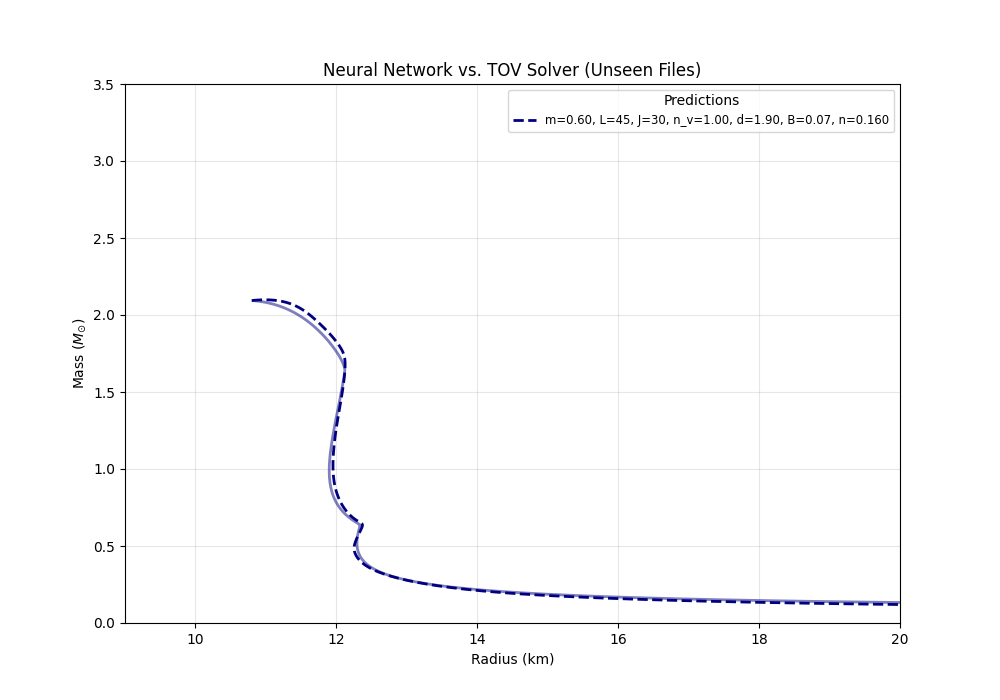

In [ ]:
save_dir = "399700files_MRTD/"

# ==============================================================================
# 1. CONFIGURATION & HELPERS
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RADIUS_SCALE = 25.0
MASS_SCALE = 3.5

# Regex must match the Training Pipeline exactly
pattern = re.compile(
    r"MREoSm(?P<m>\d+)"
    r"L(?P<L>\d+)"
    r"J(?P<J>\d+)"
    r"T(?P<T>\d+)_"
    r"n(?P<n>\d+)_"
    r"Yp0f?\+.*?RGgen_"
    r"v(?P<n_v>[-\d\.]+)"
    r"d(?P<d>[-\d\.]+)"
    r"B(?:(?P<Btype>[np]))?(?P<B>\d+)\.dat"
)

def extract_eos_params(filename):
    match = pattern.match(filename)
    if not match:
        return None
    
    # Extract raw values exactly like training
    m = float(match.group("m")) / 100.0
    L = float(match.group("L"))
    J = float(match.group("J"))
    n_v = float(match.group("n_v"))
    d = float(match.group("d"))
    B = float(match.group("B")) / 1000.0
    n = float(match.group('n')) / 1000.0  # e.g., 0.160
    
    # Return as a numpy array for easy stacking [m, L, J, n_v, d, B, n]
    return np.array([m, L, J, n_v, d, B, n], dtype=np.float32)

# ==============================================================================
# 2. SELECT "UNSEEN" FILES
# ==============================================================================
# Path to your data
DATA_DIR_PATH = "/home/kay/ML-for-Neutron-Stars/New files"

selected_files = glob.glob(os.path.join(DATA_DIR_PATH, "MR*.dat"))
print(f"Testing on {len(selected_files)} unseen files.")

# ==============================================================================
# 3. PREPARE MODEL & SCALERS
# ==============================================================================
# Load Model
model = PhysicsEmulator(input_dim=8).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(save_dir, "Best_EOS_Model.pth"), map_location=DEVICE))
model.eval()

# IMPORTANT: You must use the SAME mean/std from TRAINING.
# If you are in a new session, you should have saved these. 
# For now, assuming they exist in memory or you manually input them.
# Example: 
# X_eos_mean = torch.load("Datasets/X_eos_mean.pt")
# X_eos_std = torch.load("Datasets/X_eos_std.pt")

if 'X_eos_mean' not in locals():
        # Loading the SAME mean/std from TRAINING.
    X_eos_mean = torch.load(os.path.join(save_dir, "X_eos_mean.pt"), map_location=DEVICE)
    X_eos_std = torch.load(os.path.join(save_dir, "X_eos_std.pt"), map_location=DEVICE)
    print("ERROR: X_eos_mean and X_eos_std are missing!")
    print("You must save these during training or run this cell in the same notebook.")
else:
    X_eos_mean = X_eos_mean.to(DEVICE)
    X_eos_std = X_eos_std.to(DEVICE)

# ==============================================================================
# 4. EVALUATION LOOP
# ==============================================================================
plt.figure(figsize=(10, 7))
colors = plt.cm.jet(np.linspace(0, 1, len(selected_files)))

for color, file_path in zip(colors, selected_files):
    filename = os.path.basename(file_path)
    print("Processing file:", filename)
    eos_params = extract_eos_params(filename)
    print("EOS params:", len(eos_params) if eos_params is not None else "None")
    
    if eos_params is None: continue

    # Load Ground Truth Data
    try:
        data = np.loadtxt(file_path)
        print("Data loaded!")
    except: continue
        
    # Get cp, mass, and radius values
    mass_vals = data[:, 1]
    radius_vals = data[:, 2]
    cp_vals = data[:, 0]

    # Filter stable branch (Up to Max Mass) same as training
    max_m_idx = np.argmax(mass_vals)
    # Apply the same safety margin cut as training
    SAFETY_MARGIN = 2
    cut_idx = max(1, max_m_idx - SAFETY_MARGIN) 
    
    mass_vals = mass_vals[:cut_idx]
    radius_vals = radius_vals[:cut_idx]
    cp_vals = cp_vals[:cut_idx]

    # Basic filtering to ensure positive values
    positive_mask = (mass_vals > 0) & (radius_vals > 0)
    mass_vals = mass_vals[positive_mask]
    radius_vals = radius_vals[positive_mask]
    cp_vals = cp_vals[positive_mask]

    # ---------------------------------------------------------
    # PREPARE INPUT TENSORS (The Hybrid Normalization)
    # ---------------------------------------------------------
    
    # 1. Tile the EOS params for every mass point
    num_points = len(mass_vals)
    eos_repeated = np.tile(eos_params, (num_points, 1)) # Shape (N, 7)
    
    # 2. Convert to Tensor
    X_eos_input = torch.tensor(eos_repeated, dtype=torch.float32).to(DEVICE)
    X_cp_input = torch.tensor(cp_vals.reshape(-1, 1), dtype=torch.float32).to(DEVICE)
    
    # 3. NORMALIZE (Use training stats!)
    # EOS: Z-score
    X_eos_norm = (X_eos_input - X_eos_mean) / X_eos_std
    # CP: Log10 Scaling
    X_cp_norm   = torch.log10(X_cp_input)
    
    # 4. Concatenate
    model_input = torch.cat((X_eos_norm, X_cp_norm), dim=1)
    
    # ---------------------------------------------------------
    # PREDICT
    # ---------------------------------------------------------
    with torch.no_grad():
        # Predict normalized Mass and Radius (0.0 to ~1.0)
        
        pred = model(model_input)
        Mass_pred_norm = pred[:, 0:1]
        R_pred_norm = pred[:, 1:2]

        # De-normalize
        R_pred = R_pred_norm * RADIUS_SCALE
        Mass_pred = Mass_pred_norm * MASS_SCALE
        
        # Move to CPU for plotting
        Mass_pred = Mass_pred.cpu().numpy().flatten()
        R_pred= R_pred.cpu().numpy().flatten()

    # ---------------------------------------------------------
    # PLOT [m, L, J, n_v, d, B, n] # Label with Physics Params
    # ---------------------------------------------------------
    label_txt = f"""m={eos_params[0]:.2f}, L={eos_params[1]:.0f}, J={eos_params[2]:.0f}, n_v={eos_params[3]:.2f}, d={eos_params[4]:.2f}, B={eos_params[5]:.2f}, n={eos_params[6]:.3f}""" 
    
    # Plot Ground Truth (Solid Line)
    plt.plot(radius_vals, mass_vals, "-", color=color, alpha=0.5, linewidth=2)
    
    # Plot Prediction (Dashed Line)   
    plt.plot(R_pred, Mass_pred, "--", color=color, linewidth=2, label=label_txt)
 
plt.title("Neural Network vs. TOV Solver (Unseen Files)")
plt.xlabel("Radius (km)")
plt.ylabel(r"Mass ($M_{\odot}$)")
plt.legend(title="Predictions", fontsize='small')
plt.grid(True, alpha=0.3)
plt.xlim(9, 20) # Focus on typical NS radius range
plt.ylim(0, 3.5)
# plt.savefig(os.path.join(save_dir, "Testing plot B.png"))

plt.show()

In [5]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

orig_radius_all = radius_vals
pred_radius_all = R_pred

orig_mass_all = mass_vals
pred_mass_all = Mass_pred

mae_radius = mean_absolute_error(orig_radius_all, pred_radius_all)
rmse_radius = np.sqrt(mean_squared_error(orig_radius_all, pred_radius_all))
r2_radius = r2_score(orig_radius_all, pred_radius_all)

mae_mass = mean_absolute_error(orig_mass_all, pred_mass_all)
rmse_mass = np.sqrt(mean_squared_error(orig_mass_all, pred_mass_all))
r2_mass = r2_score(orig_mass_all, pred_mass_all)

norm_rmse = np.mean([
    rmse_radius / np.mean(orig_radius_all),
    rmse_mass / np.mean(orig_mass_all),
])

print(f"Radius:  MAE={mae_radius:.4f}, RMSE={rmse_radius:.4f}, R²={r2_radius:.4f}")
print(f"Mass:  RMSE={rmse_mass:.4f}, R²={r2_mass:.4f}")
print(f"Combined normalized RMSE = {norm_rmse:.4f}")

Radius:  MAE=1.7887, RMSE=8.1282, R²=0.5707
Mass:  RMSE=0.0181, R²=0.9993
Combined normalized RMSE = 0.2642
